<a href="https://colab.research.google.com/github/shams-mehdi/TERP/blob/main/TERP_mobilenet_celebA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Thermodynamically Explainable Representations of AI and other blackbox Paradigms (TERP)**

**Explain Mobilenet predictions trained on celebA dataset**


---
<img src="https://raw.githubusercontent.com/shams-mehdi/TERP/main/101.png">

**References:**
<br>
*   Howard, A. G., Zhu, M., Chen, B., Kalenichenko, D., Wang, W., Weyand, T., ... & Adam, H. (2017). Mobilenets: Efficient convolutional neural networks for mobile vision applications. arXiv preprint arXiv:1704.04861.
*   Liu, Z., Luo, P., Wang, X., & Tang, X. (2018). Large-scale celebfaces attributes (celeba) dataset. Retrieved August, 15(2018), 11.

In [1]:
#@title Step 0: Load libraries
import torchvision.transforms as transforms
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
from google.colab import files
from os.path import exists
from skimage.segmentation import slic, mark_boundaries, quickshift
import copy
import PIL
from sklearn.utils import check_random_state
from functools import partial
import sklearn
from skimage.color import gray2rgb
from tqdm.auto import tqdm
import sklearn.metrics as met
import moviepy.editor as mp
from IPython.display import HTML
from base64 import b64encode
import pdb
import random
import matplotlib.ticker as ticker

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2441216/45929032 bytes (5.3%)4562944/45929032 bytes (9.9%)7135232/45929032 bytes (15.5%)9125888/45929032 bytes (19.9%)11583488/45929032 bytes (25.2%)14532608/45929032 bytes (31.6%)17276928/45929032 bytes (37.6%)19947520/45929032 bytes (43.4%)22904832/45929032 bytes (49.9%)24862720/45929032 bytes (54.1%)27508736/45929032 bytes (59.9%)30474240/45929032 bytes (66.4%)337

In [7]:
#@title Step 1: Download trained mobilenet model

# Clone github repo
!npx degit tiwarylab/TERP -f

'''
All mobilenet layers are followed by batch normalization and then the
activation function. Creating 28 layer MobileNet architecture below (
counting depthwise, pointwise convolutions separately).
'''

# mish activation function
class MISH_activation(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x*(torch.tanh(F.softplus(x)))


def first_layer_full_activation(in_channels, out_channels, stride):
    return nn.Sequential(nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False),
                        nn.BatchNorm2d(out_channels),
                        MISH_activation())

def depth_point_wise_convolution(in_channels, out_channels, stride):
    return nn.Sequential(nn.Conv2d(in_channels, in_channels, 3, stride, 1, groups=in_channels, bias=False),
                        nn.BatchNorm2d(in_channels),
                        MISH_activation(),
                        nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=False),
                        nn.BatchNorm2d(out_channels),
                        MISH_activation())

class MobileNet_model(nn.Module):
    def __init__(self):
        super(MobileNet_model, self).__init__()
        self.features = nn.Sequential(
            first_layer_full_activation(  3,  32, 2), 
            depth_point_wise_convolution( 32,  64, 1),
            depth_point_wise_convolution( 64, 128, 2),
            depth_point_wise_convolution(128, 128, 1),
            depth_point_wise_convolution(128, 256, 2),
            depth_point_wise_convolution(256, 256, 1),
            depth_point_wise_convolution(256, 512, 2),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 512, 1),
            depth_point_wise_convolution(512, 1024, 2),
            depth_point_wise_convolution(1024, 1024, 1),
            nn.AvgPool2d(7),)
        self.fc = nn.Linear(1024, num_labels)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

transform = transforms.Compose([transforms.Resize((267,327)),transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

attributes = ['5_o_Clock_Shadow', 'Bald', 'Bangs', 'Blond_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'No_Beard', 'Pale_Skin', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necktie']
num_labels = len(attributes)
trained_model_path = 'MobileNets/MobileNet.pth'
model = torch.load(trained_model_path)
model.eval()
print("MobileNet model loaded successfully.")

MobileNet model loaded successfully.


**Recommendations for step 2:**

*   Frontal facial images in good lighting
*   No black-white or fuzzy images
*   Recommended resolution:  178x218
*   MobileNet model may not work for user uploaded images. For best results use provided samples

Type sample name to select an image from 100 provided samples.

In [8]:
#@title Step 2: Upload facial image 
sample_name = "celebA samples/181200.png" #@param {type:"string"}

if exists(sample_name) == True:
  fn = sample_name
  print('File exists. Selected file: ', fn)
else:
  print("File doesn't exist!")

File exists. Selected file:  celebA samples/181200.png


Detected attributes/true predictions:

Attribute index: 10, attribute:Male
Attribute index: 13, attribute:No_Beard
Attribute index: 18, attribute:Wearing_Hat

False predictions:

Attribute index: 0, attribute:5_o_Clock_Shadow
Attribute index: 1, attribute:Bald
Attribute index: 2, attribute:Bangs
Attribute index: 3, attribute:Blond_Hair
Attribute index: 4, attribute:Bushy_Eyebrows
Attribute index: 5, attribute:Chubby
Attribute index: 6, attribute:Double_Chin
Attribute index: 7, attribute:Eyeglasses
Attribute index: 8, attribute:Goatee
Attribute index: 9, attribute:Gray_Hair
Attribute index: 11, attribute:Mouth_Slightly_Open
Attribute index: 12, attribute:Mustache
Attribute index: 14, attribute:Pale_Skin
Attribute index: 15, attribute:Rosy_Cheeks
Attribute index: 16, attribute:Sideburns
Attribute index: 17, attribute:Smiling
Attribute index: 19, attribute:Wearing_Lipstick
Attribute index: 20, attribute:Wearing_Necktie


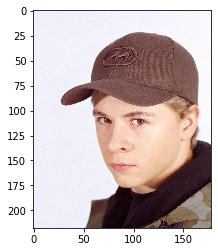

In [9]:
#@title Step 3: Pass image to MobileNet and obtain attribute predictions


plt.imshow(Image.open(fn))
image_tensor = transform(Image.open(fn))
image = torch.unsqueeze(image_tensor, 0)
image = image.to('cuda')
pred_proba = model(image)
classification = (pred_proba>0.5).cpu().numpy()[0]

true_attributes= [i for i, x in enumerate(classification) if x]
false_attributes = [i for i, x in enumerate(classification) if x==False]
print("Detected attributes/true predictions:\n")
for i in true_attributes:
  print("Attribute index: " + str(i) + ", attribute:" + attributes[i])

print("\nFalse predictions:\n")
for i in false_attributes:
  print("Attribute index: " + str(i) + ", attribute:" + attributes[i])

**Recommendations for step 4:**
*   Use the **compactness slider** to tune SLIC segmentation algorithm
*   Minimum compactness: full weight to color space
*   Maximum compactness: full weight to geometric space

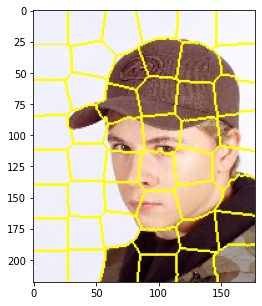

In [ ]:
#@title Step 4: Define super pixels
n_segments = 50 #@param {type:"integer"}
compactness = 120 #@param {type:"slider", min:1, max:120, step:1}

fig,ax = plt.subplots(figsize=(5, 5))
image = Image.open(fn)
segments = slic(image,n_segments=n_segments,compactness=compactness)
ax.imshow(mark_boundaries(image, segments))

**Recommendations for step 5:**
*   Choose size of generated neigborhood
*   Select attributes to explain (e.g, 20 for wearing necktie. See step 3 results. **Select only from true predictions**)

In [ ]:
#@title Step 5: Generate neighbourhood data
num_samples = 2000 #@param {type:"integer"}
explain_attribute =  18#@param {type:"integer"}
batch_size = 64
progress_bar = True
random_state = check_random_state(10)

def make_prediction(specific_image, explain_attribute):
  image_tensor = transform(specific_image)
  image = torch.unsqueeze(image_tensor, 0)
  image = image.to('cuda')
  pred_proba = model(image)
  classification = (pred_proba>0.5).cpu().numpy()
  return classification[:, explain_attribute]


rgb_image = np.array(image.getdata()).reshape((image.size[1], image.size[0],3))
fudged_image = rgb_image.copy()

n_features = np.unique(segments).shape[0]
data = random_state.randint(0, 2, num_samples * n_features).reshape((num_samples, n_features))
labels = []
data[0, :] = 1
imgs = []
print("Generating neighbourhood!")
rows = tqdm(data) if progress_bar else data
for x in np.unique(segments):
    fudged_image[segments == x] = (
        np.mean(rgb_image[segments == x][:, 0]),
        np.mean(rgb_image[segments == x][:, 1]),
        np.mean(rgb_image[segments == x][:, 2]))
for row in rows:
    temp = copy.deepcopy(rgb_image)
    zeros = np.where(row == 0)[0]
    mask = np.zeros(segments.shape).astype(bool)
    for z in zeros:
        mask[segments == z] = True
    temp[mask] = fudged_image[mask]
    imgs.append(temp)

predict_a = np.zeros((num_samples))
img_list = []
print("Fetching predictions from MobileNet (obscure model)!")
for i in range(num_samples):
    predict_a[i] = make_prediction(Image.fromarray(np.uint8(imgs[i])).convert('RGB'), explain_attribute)
    img_list.append(Image.fromarray(np.uint8(imgs[i])).convert('RGB'))
    if i%100 ==0:
        print(i)
  
img_list[0].save('perturbed.gif',
               save_all=True, append_images=img_list[1:], optimize=False, duration=200, loop=0)

predict_b = (predict_a > 0.5).astype(np.int_)
print("Neighborhood size: ", num_samples, "Number of positive samples: ", np.sum(predict_b))

Generating neighbourhood!


  0%|          | 0/2000 [00:00<?, ?it/s]

Fetching predictions from MobileNet (obscure model)!
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
Neighborhood size:  2000 Number of positive samples:  1797


**Recommendations for step 6:**
*   Perform grid search for kernel width (σ) that produces wide similarity kernel distribution (Π) for the whole neighborhood
*   grid_start should be > 0

Best sigma:  0.21142105263157895


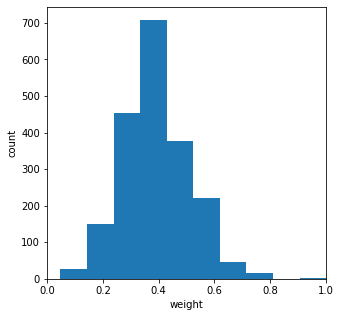

In [ ]:
#@title Step 6: Calculate representative distances and similarity measures. Visualize similarity measure distribution
grid_start = 0.001 #@param {type:"number"}
grid_end = 2 #@param {type:"number"}
num_gridpoints = 20 #@param {type:"integer"}
distance_metric = "cosine" #@param {type:"string"}

def distances_f(data):
    return met.pairwise_distances(data,data[0].reshape(1, -1),metric=distance_metric).ravel()

def kernel(d, kernel_width):
    return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

def return_weights(distances, kernel_width):
  weights = np.zeros((distances.shape[0]))
  for ik in range(distances.shape[0]):
      weights[ik] = kernel(distances[ik], kernel_width)
  return weights

distances = distances_f(data)

sigma_grid = np.linspace(grid_start, grid_end, num_gridpoints)
similarity_measure_std = []
for i in range(sigma_grid.shape[0]):
  weights = return_weights(distances, sigma_grid[i])
  similarity_measure_std.append(np.std(weights))

best_sigma = np.argmax(similarity_measure_std)
weights = return_weights(distances, sigma_grid[best_sigma])

fig2, ax2 = plt.subplots(figsize = (5,5))
ax2.hist(weights)
ax2.set_ylabel('count')
ax2.set_xlabel('weight')
ax2.set_xlim(0,1)

print("Best sigma: ", sigma_grid[best_sigma])

**Recommendations for step 7:**
*   Higher metropolis_param (α) leads to higher acceptance, i.e, more MC jumps
*   k_max sets end of forward feature selection algorithm



In [ ]:
#@title Step 7.1:: TERP:: Calculate baseline model (k=0)
MC_iterations = 10000 #@param {type:"integer"}
metropolis_param = 1 #@param {type:"number"}
seed = 0 #@param {type:"integer"}

neighbourhood_data = data
labels_collapsed = predict_a
iterations = MC_iterations
epsilon = 0.0000000000001

u0_unfaithfulness = np.zeros((iterations + 1))
u0_best_unfaithfulness = np.zeros((iterations + 1))
intercept_array = np.zeros((iterations + 1))

# Initialization
intercept_array[0] = 1

# Setup counters
total_accepted_count = 0
metropolis_accepted_count = 0
rejected_count = 0


def u0_weighted_local_model_value(weights, intercept):
    weighted_matrix = np.sqrt(weights)* intercept
    return weighted_matrix

current_step = 0
while current_step < iterations :
  R = np.random.uniform(low=0.0, high = 1.0)

  local_model_pred = u0_weighted_local_model_value(weights, intercept_array[current_step])
  weighted_obscure_model_pred = np.multiply(np.sqrt(weights), labels_collapsed)
  weighted_residual_matrix = (weighted_obscure_model_pred-local_model_pred)**2

  u0_unfaithfulness[current_step] = np.sum(weighted_residual_matrix)
  if current_step == 0:
    u0_best_unfaithfulness[0] = u0_unfaithfulness[0]

  # Draw small random numbers
  q = np.random.uniform(low = -0.5, high = 0.5, size = 1)/10
  intercept_array[current_step + 1] = intercept_array[current_step] + q

  updated_local_model_pred = u0_weighted_local_model_value(weights, intercept_array[current_step + 1])
  updated_weighted_residual_matrix = (weighted_obscure_model_pred-updated_local_model_pred)**2

  u0_unfaithfulness[current_step + 1] = np.sum(updated_weighted_residual_matrix)

  if u0_unfaithfulness[current_step + 1] < u0_unfaithfulness[current_step]:
    ## Keep the updates
    u0_best_unfaithfulness[current_step + 1 ] = np.min(u0_unfaithfulness[:current_step + 2])
    total_accepted_count += 1

  else:
    ## Reject the updates
    intercept_array[current_step + 1] = intercept_array[current_step]
    u0_best_unfaithfulness[current_step + 1 ] = np.min(u0_unfaithfulness[:current_step + 2])
    rejected_count += 1
  current_step += 1

best_u_master_2 =  [u0_best_unfaithfulness[-1]/np.sum(weights)]
print('Baseline model calculated...')

Baseline model calculated...


0: , k = 1
500: , k = 1
1000: , k = 1
1500: , k = 1
2000: , k = 1
2500: , k = 1
3000: , k = 1
3500: , k = 1
4000: , k = 1
4500: , k = 1
5000: , k = 1
5500: , k = 1
6000: , k = 1
6500: , k = 1
7000: , k = 1
7500: , k = 1
8000: , k = 1
8500: , k = 1
9000: , k = 1
9500: , k = 1


No handles with labels found to put in legend.


k =  1
3011 2914 4075
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.16378286
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 0.9700686427976148
Best unfaithfulness:  0.09776167962839798
0: , k = 2
500: , k = 2
1000: , k = 2
1500: , k = 2
2000: , k = 2
2500: , k = 2
3000: , k = 2
3500: , k = 2
4000: , k = 2
4500: , k = 2
5000: , k = 2
5500: , k = 2
6000: , k = 2
6500: , k = 2
7000: , k = 2
7500: , k = 2
8000: , k = 2
8500: , k = 2
9000: , k = 2
9500: , k = 2


No handles with labels found to put in legend.


k =  2
2896 2884 4220
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.16482199
  0.          0.          0.          0.         -0.15881654  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 1.050749700226145
Best unfaithfulness:  0.0909892356648884
0: , k = 3
500: , k = 3
1000: , k = 3
1500: , k = 3
2000: , k = 3
2500: , k = 3
3000: , k = 3
3500: , k = 3
4000: , k = 3
4500: , k = 3
5000: , k = 3
5500: , k = 3
6000: , k = 3
6500: , k = 3
7000: , k = 3
7500: , k = 3
8000: , k = 3
8500: , k = 3
9000: , k = 3
9500: , k = 3


No handles with labels found to put in legend.


k =  3
2491 2450 5059
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.17479273
  0.          0.         -0.12233173  0.         -0.19912922  0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 1.1287104835725905
Best unfaithfulness:  0.08737343368451132
0: , k = 4
500: , k = 4
1000: , k = 4
1500: , k = 4
2000: , k = 4
2500: , k = 4
3000: , k = 4
3500: , k = 4
4000: , k = 4
4500: , k = 4
5000: , k = 4
5500: , k = 4
6000: , k = 4
6500: , k = 4
7000: , k = 4
7500: , k = 4
8000: , k = 4
8500: , k = 4
9000: , k = 4
9500: , k = 4


No handles with labels found to put in legend.


k =  4
1981 2023 5996
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.11574463  0.          0.         -0.21434715
  0.          0.          0.          0.         -0.12584327  0.
 -0.07386855  0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 1.1503008946276942
Best unfaithfulness:  0.08693175487849185
0: , k = 5
500: , k = 5
1000: , k = 5
1500: , k = 5
2000: , k = 5
2500: , k = 5
3000: , k = 5
3500: , k = 5
4000: , k = 5
4500: , k = 5
5000: , k = 5
5500: , k = 5
6000: , k = 5
6500: , k = 5
7000: , k = 5
7500: , k = 5
8000: , k = 5
8500: , k = 5
9000: , k = 5
9500: , k = 5


No handles with labels found to put in legend.


k =  5
2179 2177 5644
[ 0.          0.          0.          0.         -0.02789775  0.
  0.          0.         -0.10663915  0.          0.         -0.15919374
  0.          0.          0.          0.         -0.22815076  0.
  0.          0.          0.06200009  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 1.1252205910864008
Best unfaithfulness:  0.08617513676107866
0: , k = 6
500: , k = 6
1000: , k = 6
1500: , k = 6
2000: , k = 6
2500: , k = 6
3000: , k = 6
3500: , k = 6
4000: , k = 6
4500: , k = 6
5000: , k = 6
5500: , k = 6
6000: , k = 6
6500: , k = 6
7000: , k = 6
7500: , k = 6
8000: , k = 6
8500: , k = 6
9000: , k = 6
9500: , k = 6


No handles with labels found to put in legend.


k =  6
2213 2248 5539
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.16538339
  0.          0.         -0.14813106  0.         -0.15611384  0.
  0.          0.          0.05509528  0.          0.          0.
  0.          0.          0.          0.          0.05918843  0.
  0.          0.          0.          0.          0.          0.
  0.         -0.06397442  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.        ] 1.0947607665600754
Best unfaithfulness:  0.08546149113048612
0: , k = 7
500: , k = 7
1000: , k = 7
1500: , k = 7
2000: , k = 7
2500: , k = 7
3000: , k = 7
3500: , k = 7
4000: , k = 7
4500: , k = 7
5000: , k = 7
5500: , k = 7
6000: , k = 7
6500: , k = 7
7000: , k = 7
7500: , k = 7
8000: , k = 7
8500: , k = 7
9000: , k = 7
9500: , k = 7
k =  7
2249 2269 5482
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 

No handles with labels found to put in legend.


0: , k = 8
500: , k = 8
1000: , k = 8
1500: , k = 8
2000: , k = 8
2500: , k = 8
3000: , k = 8
3500: , k = 8
4000: , k = 8
4500: , k = 8
5000: , k = 8
5500: , k = 8
6000: , k = 8
6500: , k = 8
7000: , k = 8
7500: , k = 8
8000: , k = 8
8500: , k = 8
9000: , k = 8
9500: , k = 8


No handles with labels found to put in legend.


k =  8
2055 2063 5882
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.65383386e-01
  0.00000000e+00  0.00000000e+00 -1.48131064e-01  0.00000000e+00
 -1.56113842e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.50952835e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-13
  5.91884349e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.39744242e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00] 1.0947607665600754
Best unfaithfulness:  0.08546149113048455
0: , k = 9
500: , k = 9
1000: , k = 9
1500: , k = 9
2000: , k = 9
2500: , k = 9
3000: , k = 9
3500: , k = 9
4000: , k = 9
4500: , k = 9


No handles with labels found to put in legend.


k =  9
2102 2010 5888
No improvement at k =  9 Adding coefficients, intercept, last iteration value of best unfaithfulness from (k-1) values!
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.65383386e-01
  0.00000000e+00  0.00000000e+00 -1.48131064e-01  0.00000000e+00
 -1.56113842e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.50952835e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-13
  5.91884349e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.39744242e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00] 1.0947607665600754
Best unfaithfulness:  0.08546149113048455
0: , k = 10
500:

No handles with labels found to put in legend.


k =  10
2046 2115 5839
No improvement at k =  10 Adding coefficients, intercept, last iteration value of best unfaithfulness from (k-1) values!
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.65383386e-01
  0.00000000e+00  0.00000000e+00 -1.48131064e-01  0.00000000e+00
 -1.56113842e-01  0.00000000e+00  0.00000000e+00  0.00000000e+00
  5.50952835e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-13
  5.91884349e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -6.39744242e-02  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00] 1.0947607665600754
Best unfaithfulness:  0.08546149113048455


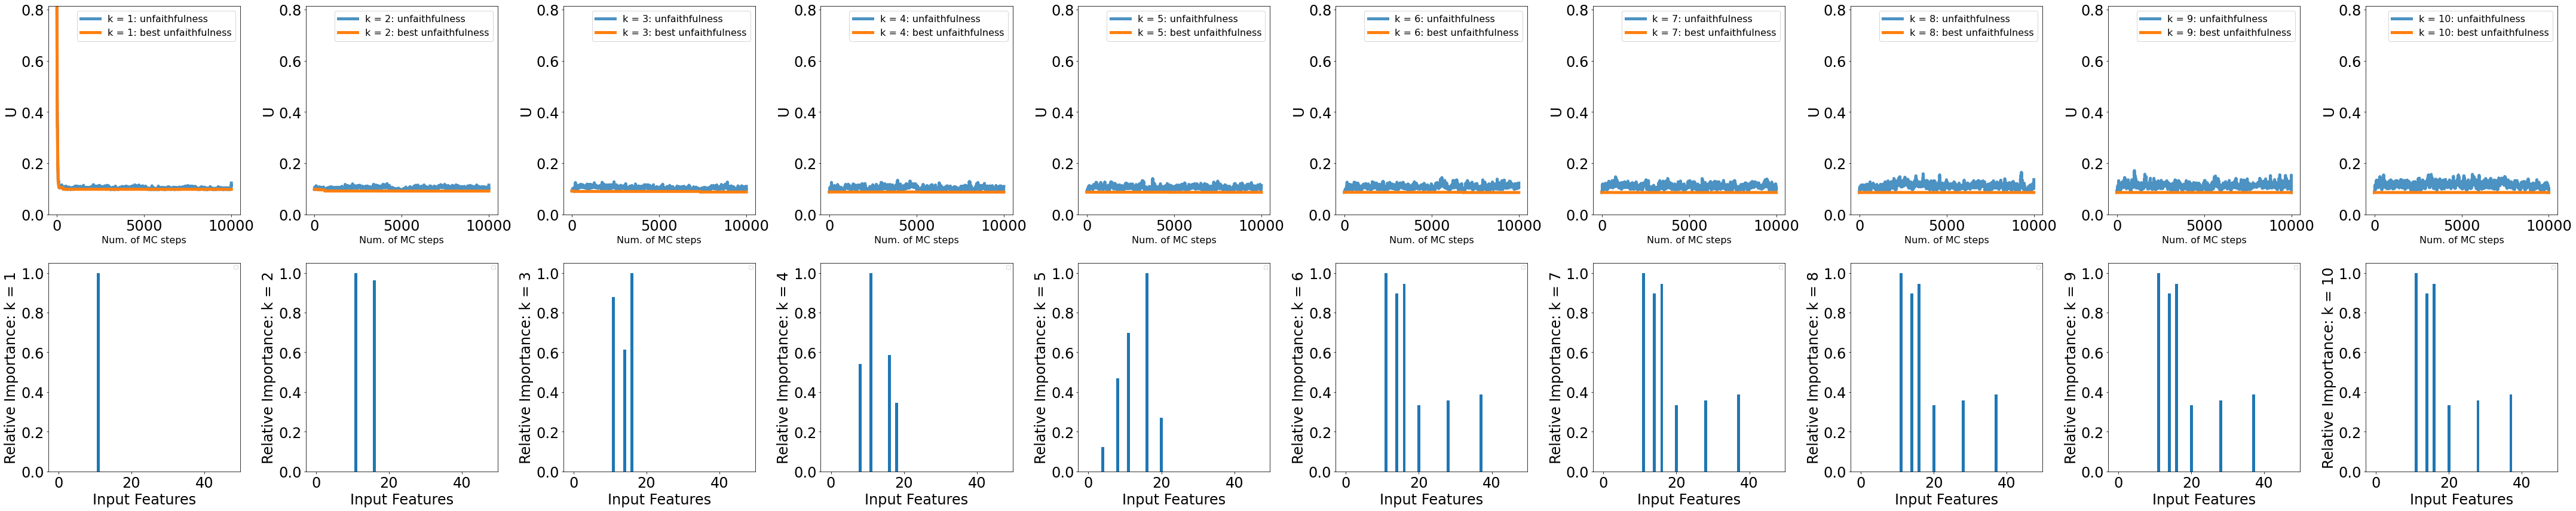

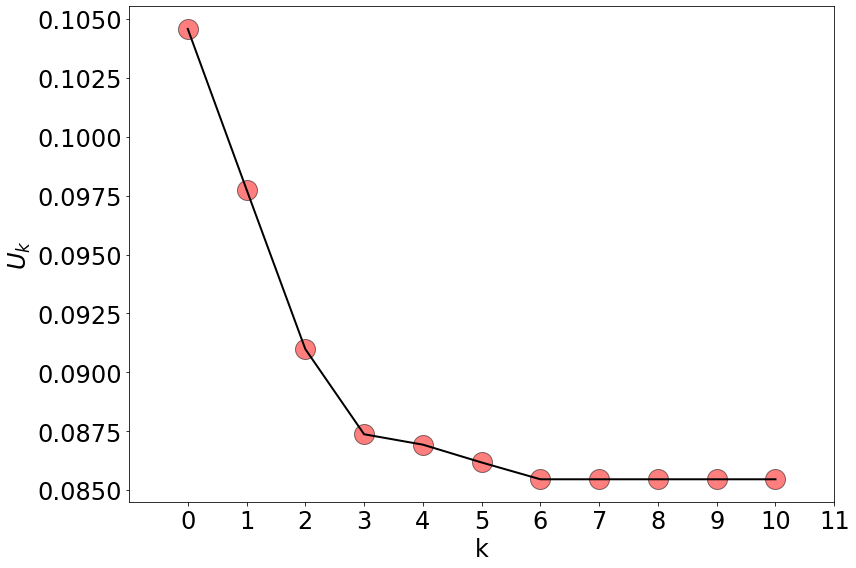

In [ ]:
#@title Step 7.2:: TERP:: Forward feature selection using Monte Carlo algorithm (0<k<=k_max)

k_max =  10#@param {type:"integer"}
TERP_detailed_report = "yes" #@param {type:"string"}
calc_clip = k_max

N = neighbourhood_data.shape[1]
k_array = np.arange(calc_clip)+1
random.seed(seed)
np.random.seed(seed)

def weighted_local_model_value(data, weights, coefficient_array, intercept):
    local_model_mat = np.zeros((data.shape[0], data.shape[1]))
    for i in range(data.shape[1]):
      local_model_mat[:,i] = data[:,i] * coefficient_array[i]
    matrix = np.sum(local_model_mat, axis = 1) + intercept
    weighted_matrix = np.multiply(np.sqrt(weights), matrix)
    return weighted_matrix

def unfaithfulness_calc(k, N, neighbourhood_data, labels, weights, T, iterations, inherit, inheritance_values):
  tot_weight = np.sum(weights)
  k_random_draws = np.random.choice(np.arange(N),size = k, replace = False)
  weighted_obscure_model_pred = np.multiply(np.sqrt(weights), labels)
  
  coefficient_array = np.zeros((iterations + 1, N))
  intercept_array = np.zeros((iterations + 1))

  unfaithfulness = np.zeros((iterations + 1))
  best_unfaithfulness = np.zeros((iterations + 1))

  # Initialization
  intercept_array[0] = 1
  for i in range(k):
    coefficient_array[0, k_random_draws[i]] = 1

  # Initialization with inheritance, i.e, coefficients inherited from previous iteration
  if inherit == 'yes':
    coefficient_array[0, :] = inheritance_values[0]
    intercept_array[0] = inheritance_values[1]

    inherited_nonzero = np.nonzero(coefficient_array[0, :])[0]
    zeros_to_perturb =  k - inherited_nonzero.shape[0]
    inherited_zero = np.where(coefficient_array[0, :] == 0)[0]
    needed_random_draws = np.random.choice(inherited_zero, size = zeros_to_perturb, replace = False)

    for j in range(k_random_draws.shape[0] - zeros_to_perturb):
      k_random_draws[j] = inherited_nonzero[j]
    for j in range(needed_random_draws.shape[0]):
      k_random_draws[-j] = needed_random_draws[j]
      coefficient_array[0, k_random_draws[-j]] = epsilon

  total_accepted_count = 0
  metropolis_accepted_count = 0
  rejected_count = 0

  current_step = 0
  while current_step < iterations :
    R = np.random.uniform(low=0.0, high = 1.0)
    local_model_pred = weighted_local_model_value(neighbourhood_data, weights, coefficient_array[current_step, :], intercept_array[current_step])
    weighted_residual_matrix = (weighted_obscure_model_pred-local_model_pred)**2
    unfaithfulness[current_step] = np.sum(weighted_residual_matrix)

    if current_step == 0:
      best_unfaithfulness[0] = unfaithfulness[0]

    nonzero_coefficient_indices = np.nonzero(coefficient_array[current_step, :])[0]
    assert len(nonzero_coefficient_indices) == k

    # Draw small random numbers
    q = np.random.uniform(low = -0.5, high = 0.5, size = k+1)/10
    for i in range(len(nonzero_coefficient_indices)):
      coefficient_array[current_step + 1, nonzero_coefficient_indices[i]] = coefficient_array[current_step, nonzero_coefficient_indices[i]] + q[i]
    intercept_array[current_step + 1] = intercept_array[current_step] + q[k]
    
    # Swap coefficients using tuple unpacking
    p = np.random.choice(np.arange(N),size = 1, replace = True)
    p2 = np.random.choice(np.arange(len(nonzero_coefficient_indices)),size = 1, replace = True)
    coefficient_array[current_step + 1, k_random_draws[p2]], coefficient_array[current_step + 1, p] = coefficient_array[current_step + 1, p], coefficient_array[current_step + 1, k_random_draws[p2]]

    updated_local_model_pred = weighted_local_model_value(neighbourhood_data, weights, coefficient_array[current_step + 1, :], intercept_array[current_step + 1])
    updated_weighted_residual_matrix = (weighted_obscure_model_pred-updated_local_model_pred)**2

    unfaithfulness[current_step + 1] = np.sum(updated_weighted_residual_matrix)

    if unfaithfulness[current_step + 1] < unfaithfulness[current_step]:
      ## Keep the updates
      best_unfaithfulness[current_step + 1 ] = np.min(unfaithfulness[:current_step + 2])
      total_accepted_count += 1
    elif np.exp(-(np.sum(updated_weighted_residual_matrix)-np.sum(weighted_residual_matrix))/(np.sqrt(k+1)*metropolis_param)) > R:
      ## Keep the updates
      best_unfaithfulness[current_step + 1 ] = np.min(unfaithfulness[:current_step + 2])
      metropolis_accepted_count += 1
    else:
      ## Reject updates
      coefficient_array[current_step + 1, :] = coefficient_array[current_step, :]
      intercept_array[current_step + 1] = intercept_array[current_step]
      best_unfaithfulness[current_step + 1 ] = np.min(unfaithfulness[:current_step + 2])
      rejected_count += 1
    
    if current_step%500 ==0:
        print(str(current_step) + ': , k = ' + str(k))
    current_step += 1
  print('k = ', k)
  print("Accepted_count: ", total_accepted_count, "\nMetropolis_accepted_count", metropolis_accepted_count, "\nRejected_count", rejected_count)
  if inherit == "no":
    return coefficient_array, intercept_array, unfaithfulness/tot_weight, best_unfaithfulness/tot_weight
  elif best_unfaithfulness[-1]/tot_weight < best_u_master[k-2]:
    return coefficient_array, intercept_array, unfaithfulness/tot_weight, best_unfaithfulness/tot_weight
  else:
    print("No improvement at k = ", k, "Adding coefficients, intercept, last iteration value of best unfaithfulness from (k-1) values!")
    ## in the indices below used -2 instead of -1 because here k starts from 1, while list indices start from 0
    coefficient_array = np.vstack((coefficient_array, best_coefficients[k-2]))
    intercept_array = np.append(intercept_array, best_intercepts[k-2])
    unfaithfulness = np.append(unfaithfulness, best_u_master[k-2]*tot_weight)
    best_unfaithfulness = np.append(best_unfaithfulness, best_u_master[k-2]*tot_weight)
    return coefficient_array, intercept_array, unfaithfulness/tot_weight, best_unfaithfulness/tot_weight


worse_u_master = []
best_u_master = []
best_coefficients = []
best_intercepts = []

if TERP_detailed_report == 'yes':
  fig, ax = plt.subplots(2, calc_clip, figsize = (6*calc_clip, 6*2))
inherit = "no"
inheritance_values = 'null'
for k in k_array:
  coefficient_array, intercept_array, unfaithfulness, best_unfaithfulness = unfaithfulness_calc(k,N, neighbourhood_data, labels_collapsed, weights, metropolis_param, iterations, inherit, inheritance_values)

  best_model_index = np.where(unfaithfulness == best_unfaithfulness[-1])[0][0]
  print(coefficient_array[best_model_index, :], intercept_array[best_model_index])
  best_coefficients.append(coefficient_array[best_model_index, :])
  best_intercepts.append(intercept_array[best_model_index])
  inheritance_values = [coefficient_array[best_model_index, :], intercept_array[best_model_index]]
  inherit = 'yes'

  assert best_unfaithfulness[-1] == np.min(unfaithfulness)
  print("Best unfaithfulness: ", unfaithfulness[best_model_index])
  best_u_master.append(best_unfaithfulness[-1])
  worse_u_master.append(np.max(best_unfaithfulness))
  abs_val = np.absolute(coefficient_array[best_model_index, :])

  if TERP_detailed_report == 'yes':
    ax[0, k-1].plot(unfaithfulness, linewidth = 5, alpha = 0.8, label = 'k = ' + str(k) + ': unfaithfulness')
    ax[0, k-1].plot(best_unfaithfulness, linewidth = 5, alpha = 1.0, label = 'k = ' + str(k) + ': best unfaithfulness')
    ax[1, k-1].bar(np.arange(abs_val.shape[0]), abs_val/np.max(abs_val) )
    ax[0, k-1].set_xlabel('Num. of MC steps', fontsize = 16)
    ax[0, k-1].tick_params(axis='x', labelsize= 24)
    ax[0, k-1].set_ylabel('U', fontsize = 24)
    ax[0, k-1].tick_params(axis='y', labelsize= 24)
    ax[0, k-1].legend(loc="best", numpoints=1, fontsize=16)
    ax[1, k-1].set_xlabel('Input Features', fontsize = 24)
    ax[1, k-1].tick_params(axis='x', labelsize= 24)
    ax[1, k-1].set_ylabel('Relative Importance: k = ' + str(k), fontsize = 24)
    ax[1, k-1].tick_params(axis='y', labelsize= 24)
    ax[1, k-1].legend(loc="best", numpoints=1, fontsize=8)


best_u_master_2 += best_u_master
if TERP_detailed_report == 'yes':
  for k in k_array:
    ax[0, k-1].set_ylim(0, np.max(worse_u_master))
  fig.tight_layout()
  fig2, ax2 = plt.subplots(figsize = (12,8))
  ax2.plot(best_u_master_2, 'o', markersize = 20, markeredgecolor = 'k', color = 'red', alpha = 0.5)
  ax2.plot(best_u_master_2, color = 'k', linewidth = 2)
  ax2.set_xlabel('k', fontsize = 24)
  ax2.set_xticks(np.arange(N))
  ax2.set_xticklabels(np.arange(N))
  ax2.tick_params(axis='x', labelsize= 24)
  ax2.set_ylabel(r'$U_{k}$', fontsize = 24)
  ax2.tick_params(axis='y', labelsize= 24)
  ax2.set_xlim(-1,calc_clip+1)
  fig2.tight_layout()

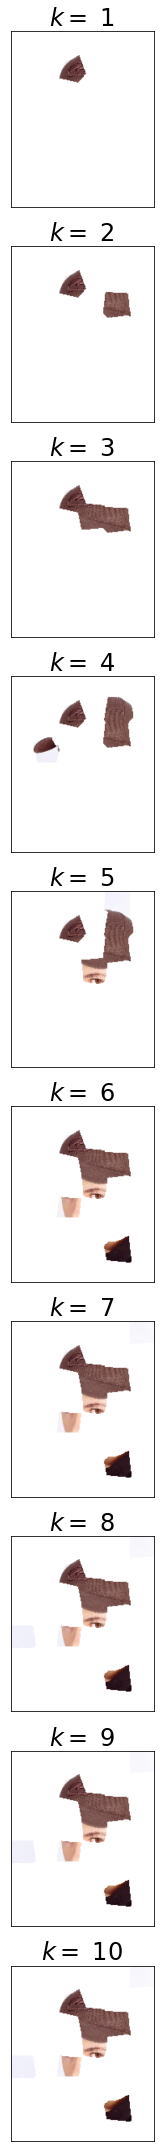

In [ ]:
#@title Step 8: Visualize relevant features/super-pixels
best_coefficients = np.array(best_coefficients)

fig, ax = plt.subplots(calc_clip, 1, figsize = (3,3*calc_clip))
for ikk in range(best_coefficients.shape[0]):
    coef_mat = np.array(image.getdata()).reshape((image.size[1], image.size[0],3))

    for i in range(segments.shape[0]):
        for j in range(segments.shape[1]):
            x = int(segments[i,j])

            if best_coefficients[ikk,x] == 0:
                coef_mat[i,j,0] = 255
                coef_mat[i,j,1] = 255
                coef_mat[i,j,2] = 255
                
    ax[ikk].imshow(coef_mat, cmap=plt.cm.viridis, alpha=1.0, interpolation='bilinear')
    ax[ikk].xaxis.set_major_locator(ticker.NullLocator())
    ax[ikk].yaxis.set_major_locator(ticker.NullLocator())
    ax[ikk].set_title('$k=$ ' + str(ikk+1), fontsize = 24)
fig.tight_layout()

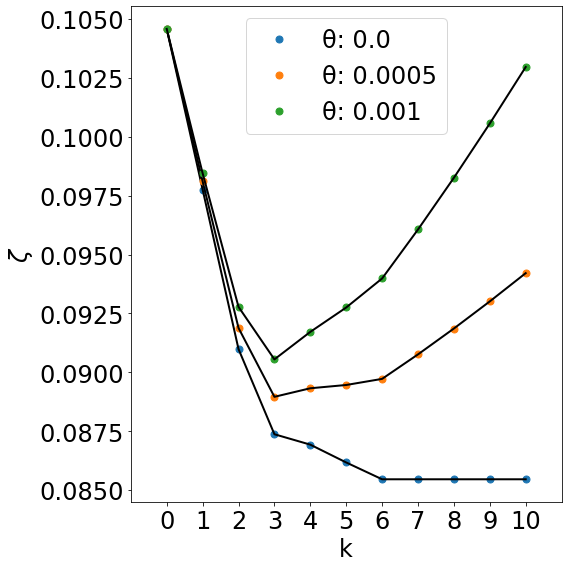

In [ ]:
#@title Step 9: Compute interpretation free energy (ζ) for various valus of (θ)

theta_01 =  0.00000#@param {type:"number"}
theta_02 =  0.0005#@param {type:"number"}
theta_03 =  0.001#@param {type:"number"}

fig2, ax2 = plt.subplots(figsize = (8,8))
N = calc_clip
theta = [theta_01, theta_02, theta_03]
def zeta(u, alpha):
    zeta = []
    for j in range(len(u)):
        zeta.append(u[j] + alpha*np.log(np.math.factorial(j+1))) 
    return zeta

zeta_master = []
for i in range(len(theta)):
    zeta_val = zeta(best_u_master_2, theta[i])
    ax2.plot(zeta_val, 'o', markersize = 7, label = 'θ: ' + str(theta[i]))
    ax2.plot(zeta_val, color = 'k', linewidth = 2)
    zeta_master.append(zeta_val)

ax2.set_xlabel('k', fontsize = 24)
ax2.set_xticks(np.arange(N+1))
ax2.set_xticklabels(np.arange(N+1))
ax2.tick_params(axis='x', labelsize= 24)
ax2.set_ylabel('$ζ$', fontsize = 24)
ax2.tick_params(axis='y', labelsize= 24)
ax2.legend(loc='best', numpoints=1, fontsize=24)
ax2.set_xlim(-1,calc_clip+1)
fig2.tight_layout()